In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-06 # Learning rate of the network
test_rate=0.3 # Defines the ratio of training dataset and test dataset
n_data = 11 # Number of txt files from which the aerodynamic coefficients are extracted
#batch_size = 100 # Mini-batch size

### Case classficiation depending on the $\beta$ and $h$
The table below informs the users the case number and corresponding geometric parameters, i.e. in this case, $\beta$, the inclination of the Gurney flap, and $h$, the length of the Gurney flap. The rows designate the value of $h$, and the columns correspond to the $\beta$. Inside each cells are the number of case. For example, when $\beta=30^{\circ}$ and $h=0.02$, then the parameters are for the case 4.   
   
|$\beta$$\backslash$ $h$|0.01|0.02|0.03|
|:--:|:---:|:---:|:---:|
|30|1|4|7|
|45|2|5|8|
|60|16|17|18|
|75|19|20|21|
|90|13|14|15|

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
beta = np.linspace(30, 90, 5)

In [5]:
## Case table (the table above!)
col1 = [1,2,16,19,13]
col2 = [4,5,17,20,14]
col3 = [7,8,18,21,15]
data_raw = [col1,col2,col3]
dataTable = pd.DataFrame(data=np.array(data_raw).T, index= beta, columns=h)

In [6]:
dataTable

,0.01,0.02,0.03
30.0,1,4,7
45.0,2,5,8
60.0,16,17,18
75.0,19,20,21
90.0,13,14,15


In [7]:
beta = beta.reshape((-1,1))
h = h.reshape((-1,1))

In [8]:
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps

In [9]:
## Creating output dataset - Cm data
# Also, time step is extracted from these files, as input data
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [10]:
import re

In [11]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-1],] + cm_target[:-1]

In [12]:
cm_df = pd.DataFrame()
for i, file in enumerate(cm_target):
    data = pd.read_csv(file, header=None)
    cm_df = pd.concat([cm_df, data], axis=0)

In [13]:
t_Cm_imp = cm_df.iloc[:,:].values

In [14]:
t_key = (t_Cm_imp[:,0]>=14) & (t_Cm_imp[:,0]<=15)

In [15]:
t = t_Cm_imp[t_key][:,0]
cm = t_Cm_imp[t_key][:,1]

In [16]:
checkpoint = []
for i in range(0,len(t)-1):
    sub_ = t[i+1] - t[i]
    if sub_ < 0:
        print(i+1)
        checkpoint.append(i+1)
    else:
        pass

786
1487
2185
2977
3699
4505
5264
6268
7245
8244


In [17]:
checkpoint = [0] + checkpoint + [len(t)]
print(checkpoint)

[0, 786, 1487, 2185, 2977, 3699, 4505, 5264, 6268, 7245, 8244, 8943]


In [18]:
# Length of each interval(=each data file) 14rev ~ 15rev
dataLength = []
for i in range(0,len(checkpoint)-1):
    dataLength.append(checkpoint[i+1]-checkpoint[i])

In [19]:
data_number = np.array(sorted(np.array(data_raw).ravel()))

In [20]:
bb = np.zeros((dataLength[0],1))
for idx, num in enumerate(range(1, 17)):
    beta_bool = dataTable.isin([num]) # 
    if np.any(beta_bool.any(True).values == True) == False:
        continue
    
    idx_x, idx_y = np.where(dataTable.isin([num]).values==True)
    idx_x = int(idx_x)
    idx_y = int(idx_y)
        
    beta_array = beta[idx_x]*np.ones((dataLength[np.where(data_number==num)[0][0]+1],1))
    bb = np.vstack((bb, beta_array))

In [21]:
hh = np.zeros((dataLength[0],1))
for idx, num in enumerate(range(1, 17)):
    h_bool = dataTable.isin([num]) # 
    if np.any(h_bool.any(True).values == True) == False:
        continue
    
    idx_x, idx_y = np.where(dataTable.isin([num]).values==True)
    idx_x = int(idx_x)
    idx_y = int(idx_y)
        
    h_array = h[idx_y]*np.ones((dataLength[np.where(data_number==num)[0][0]+1],1))
    hh = np.vstack((hh, h_array))

In [22]:
hh.shape

(8943, 1)

In [23]:
## Normalization (Adjust the scales of all of input data)
# Normalize time data(t) by subtracting 14 from original data
t = t - 14

# Normalize beta and h
bb = bb / np.max(beta)
hh = hh / np.max(h)

In [24]:
x_para = np.hstack((t.reshape((-1,1)),hh,bb))

In [25]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [26]:
baseline_coord = data.iloc[:,:].values

In [27]:
standard_coord = baseline_coord.reshape((1, -1))

In [28]:
airfoil_coord = np.repeat(standard_coord, len(t), axis=0)
print(airfoil_coord.shape)

(8943, 100)


In [29]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [30]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [31]:
flap_total0 = np.hstack((standard_coord, np.zeros((1,flap_coords.shape[1]))))
flap_total1 = np.hstack((standard_coord, flap_coords[0,:].reshape((1,10))))
flap_total2 = np.hstack((standard_coord, flap_coords[1,:].reshape((1,10))))
flap_total4 = np.hstack((standard_coord, flap_coords[5,:].reshape((1,10))))
flap_total5 = np.hstack((standard_coord, flap_coords[6,:].reshape((1,10))))
flap_total7 = np.hstack((standard_coord, flap_coords[10,:].reshape((1,10))))
flap_total8 = np.hstack((standard_coord, flap_coords[11,:].reshape((1,10))))
flap_total13 = np.hstack((standard_coord, flap_coords[4,:].reshape((1,10))))
flap_total14 = np.hstack((standard_coord, flap_coords[9,:].reshape((1,10))))
flap_total15 = np.hstack((standard_coord, flap_coords[14,:].reshape((1,10))))
flap_total16 = np.hstack((standard_coord, flap_coords[2,:].reshape((1,10))))

In [32]:
coord0 = np.repeat(flap_total0, int(dataLength[0]), axis=0)
coord1 = np.repeat(flap_total1, int(dataLength[1]), axis=0)
coord2 = np.repeat(flap_total2, int(dataLength[2]), axis=0)
coord4 = np.repeat(flap_total4, int(dataLength[3]), axis=0)
coord5 = np.repeat(flap_total5, int(dataLength[4]), axis=0)
coord7 = np.repeat(flap_total7, int(dataLength[5]), axis=0)
coord8 = np.repeat(flap_total8, int(dataLength[6]), axis=0)
coord13 = np.repeat(flap_total13, int(dataLength[7]), axis=0)
coord14 = np.repeat(flap_total14, int(dataLength[8]), axis=0)
coord15 = np.repeat(flap_total15, int(dataLength[9]), axis=0)
coord16 = np.repeat(flap_total16, int(dataLength[10]), axis=0)

In [33]:
coord = np.vstack((coord0,coord1,coord2,coord4,coord5,coord7,coord8,coord13,coord14,coord15,coord16))

In [34]:
x = np.hstack((x_para,coord))

In [35]:
y = cm.reshape((-1,1))

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [37]:
tf.keras.backend.set_image_data_format('channels_last')

In [38]:
input_data = tf.keras.Input(shape=(113))

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc5)
# MLP(FC layer)-based
model = tf.keras.Model(input_data, output_data)

In [39]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 128)               14592     
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 128)               16512     
                                                                 
 outputLayer (Dense)         (None, 1)                 129   

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [41]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=400, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=50, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-08,
                                          verbose=1)

In [42]:
STEP_SIZE_TRAIN = len(x_train)//batch_size

In [43]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=10000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/10000
62/62 [==============================] - 1s 4ms/step - loss: 0.0626 - rmse: 0.2501 - lr: 1.0000e-06
Epoch 2/10000
62/62 [==============================] - 0s 3ms/step - loss: 0.0629 - rmse: 0.2508 - lr: 1.0000e-06
Epoch 3/10000
62/62 [==============================] - 0s 3ms/step - loss: 0.0628 - rmse: 0.2507 - lr: 1.0000e-06
Epoch 4/10000
62/62 [==============================] - 0s 3ms/step - loss: 0.0627 - rmse: 0.2505 - lr: 1.0000e-06
Epoch 5/10000
62/62 [==============================] - 0s 4ms/step - loss: 0.0628 - rmse: 0.2505 - lr: 1.0000e-06
Epoch 6/10000
62/62 [==============================] - 0s 4ms/step - loss: 0.0627 - rmse: 0.2504 - lr: 1.0000e-06
Epoch 7/10000
62/62 [==============================] - 0s 3ms/step - loss: 0.0627 - rmse: 0.2503 - lr: 1.0000e-06
Epoch 8/10000
62/62 [==============================] - 0s 3ms/step - loss: 0.0037 - rmse: 0.0610 - lr: 1.0000e-06
Epoch 9/10000
62/62 [==============================] - 0s 3ms/step - loss: 0.1214 - rmse

Epoch 143/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0611 - rmse: 0.2471 - lr: 1.0000e-06
Epoch 144/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0611 - rmse: 0.2472 - lr: 1.0000e-06
Epoch 145/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0611 - rmse: 0.2472 - lr: 1.0000e-06
Epoch 146/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0610 - rmse: 0.2469 - lr: 1.0000e-06
Epoch 147/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0611 - rmse: 0.2471 - lr: 1.0000e-06
Epoch 148/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0610 - rmse: 0.2471 - lr: 1.0000e-06
Epoch 149/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0025 - rmse: 0.0499 - lr: 1.0000e-06
Epoch 150/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1196 - rmse: 0.3458 - lr: 1.0000e-06
Epoch 151/10000
62/62 [==============================] - 0s 5ms/step - l

62/62 [==============================] - 0s 5ms/step - loss: 0.0604 - rmse: 0.2457 - lr: 1.0000e-06
Epoch 284/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0604 - rmse: 0.2457 - lr: 1.0000e-06
Epoch 285/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0603 - rmse: 0.2457 - lr: 1.0000e-06
Epoch 286/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1188 - rmse: 0.3447 - lr: 1.0000e-06
Epoch 287/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0441 - lr: 1.0000e-06
Epoch 288/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0603 - rmse: 0.2456 - lr: 1.0000e-06
Epoch 289/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1188 - rmse: 0.3447 - lr: 1.0000e-06
Epoch 290/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0603 - rmse: 0.2456 - lr: 1.0000e-06
Epoch 291/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0603 - rm

62/62 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0382 - lr: 1.0000e-06
Epoch 424/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1181 - rmse: 0.3437 - lr: 1.0000e-06
Epoch 425/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0384 - lr: 1.0000e-06
Epoch 426/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0598 - rmse: 0.2446 - lr: 1.0000e-06
Epoch 427/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1181 - rmse: 0.3437 - lr: 1.0000e-06
Epoch 428/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0380 - lr: 1.0000e-06
Epoch 429/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0598 - rmse: 0.2446 - lr: 1.0000e-06
Epoch 430/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0598 - rmse: 0.2445 - lr: 1.0000e-06
Epoch 431/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0598 - rm

62/62 [==============================] - 0s 5ms/step - loss: 0.0594 - rmse: 0.2437 - lr: 1.0000e-06
Epoch 564/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0594 - rmse: 0.2437 - lr: 1.0000e-06
Epoch 565/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0594 - rmse: 0.2437 - lr: 1.0000e-06
Epoch 566/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0594 - rmse: 0.2437 - lr: 1.0000e-06
Epoch 567/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0594 - rmse: 0.2437 - lr: 1.0000e-06
Epoch 568/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0590 - rmse: 0.2429 - lr: 1.0000e-06
Epoch 569/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0594 - rmse: 0.2437 - lr: 1.0000e-06
Epoch 570/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0594 - rmse: 0.2437 - lr: 1.0000e-06
Epoch 571/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0594 - rm

62/62 [==============================] - 0s 5ms/step - loss: 8.7055e-04 - rmse: 0.0295 - lr: 1.0000e-06
Epoch 704/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1173 - rmse: 0.3424 - lr: 1.0000e-06
Epoch 705/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0591 - rmse: 0.2430 - lr: 1.0000e-06
Epoch 706/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0590 - rmse: 0.2430 - lr: 1.0000e-06
Epoch 707/10000
62/62 [==============================] - 0s 5ms/step - loss: 8.6928e-04 - rmse: 0.0295 - lr: 1.0000e-06
Epoch 708/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1172 - rmse: 0.3424 - lr: 1.0000e-06
Epoch 709/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0591 - rmse: 0.2430 - lr: 1.0000e-06
Epoch 710/10000
62/62 [==============================] - 0s 5ms/step - loss: 8.6587e-04 - rmse: 0.0294 - lr: 1.0000e-06
Epoch 711/10000
62/62 [==============================] - 0s 5ms/step - loss:

62/62 [==============================] - 0s 5ms/step - loss: 0.1169 - rmse: 0.3419 - lr: 1.0000e-06
Epoch 844/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0588 - rmse: 0.2424 - lr: 1.0000e-06
Epoch 845/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0588 - rmse: 0.2424 - lr: 1.0000e-06
Epoch 846/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0588 - rmse: 0.2424 - lr: 1.0000e-06
Epoch 847/10000
62/62 [==============================] - 0s 5ms/step - loss: 6.1987e-04 - rmse: 0.0249 - lr: 1.0000e-06
Epoch 848/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1169 - rmse: 0.3419 - lr: 1.0000e-06
Epoch 849/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0588 - rmse: 0.2424 - lr: 1.0000e-06
Epoch 850/10000
62/62 [==============================] - 0s 5ms/step - loss: 6.3458e-04 - rmse: 0.0252 - lr: 1.0000e-06
Epoch 851/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1

62/62 [==============================] - 0s 5ms/step - loss: 0.0585 - rmse: 0.2419 - lr: 1.0000e-06
Epoch 984/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0585 - rmse: 0.2420 - lr: 1.0000e-06
Epoch 985/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0585 - rmse: 0.2419 - lr: 1.0000e-06
Epoch 986/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1166 - rmse: 0.3414 - lr: 1.0000e-06
Epoch 987/10000
62/62 [==============================] - 0s 5ms/step - loss: 4.8221e-04 - rmse: 0.0220 - lr: 1.0000e-06
Epoch 988/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0585 - rmse: 0.2419 - lr: 1.0000e-06
Epoch 989/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1166 - rmse: 0.3414 - lr: 1.0000e-06
Epoch 990/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0585 - rmse: 0.2419 - lr: 1.0000e-06
Epoch 991/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0585 

Epoch 1053/10000
62/62 [==============================] - 0s 5ms/step - loss: 4.2765e-04 - rmse: 0.0207 - lr: 1.0000e-06
Epoch 1054/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0585 - rmse: 0.2418 - lr: 1.0000e-06
Epoch 1055/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1165 - rmse: 0.3413 - lr: 1.0000e-06
Epoch 1056/10000
62/62 [==============================] - 0s 5ms/step - loss: 4.3220e-04 - rmse: 0.0208 - lr: 1.0000e-06
Epoch 1057/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0584 - rmse: 0.2417 - lr: 1.0000e-06
Epoch 1058/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0584 - rmse: 0.2418 - lr: 1.0000e-06
Epoch 1059/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0584 - rmse: 0.2418 - lr: 1.0000e-06
Epoch 1060/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0584 - rmse: 0.2418 - lr: 1.0000e-06
Epoch 1061/10000
62/62 [==============================] 

62/62 [==============================] - 0s 5ms/step - loss: 0.1163 - rmse: 0.3410 - lr: 1.0000e-06
Epoch 1192/10000
62/62 [==============================] - 0s 5ms/step - loss: 3.9175e-04 - rmse: 0.0198 - lr: 1.0000e-06
Epoch 1193/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0583 - rmse: 0.2415 - lr: 1.0000e-06
Epoch 1194/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0583 - rmse: 0.2415 - lr: 1.0000e-06
Epoch 1195/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0583 - rmse: 0.2415 - lr: 1.0000e-06
Epoch 1196/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0583 - rmse: 0.2415 - lr: 1.0000e-06
Epoch 1197/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0583 - rmse: 0.2415 - lr: 1.0000e-06
Epoch 1198/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0580 - rmse: 0.2407 - lr: 1.0000e-06
Epoch 1199/10000
62/62 [==============================] - 0s 5ms/step - loss:

62/62 [==============================] - 0s 5ms/step - loss: 0.0583 - rmse: 0.2414 - lr: 5.0000e-07
Epoch 1329/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0583 - rmse: 0.2414 - lr: 5.0000e-07
Epoch 1330/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0583 - rmse: 0.2414 - lr: 5.0000e-07
Epoch 1331/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0583 - rmse: 0.2414 - lr: 5.0000e-07
Epoch 1332/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0583 - rmse: 0.2414 - lr: 5.0000e-07
Epoch 1333/10000
62/62 [==============================] - 0s 5ms/step - loss: 3.6470e-04 - rmse: 0.0191 - lr: 5.0000e-07
Epoch 1334/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1162 - rmse: 0.3408 - lr: 5.0000e-07
Epoch 1335/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0583 - rmse: 0.2414 - lr: 5.0000e-07
Epoch 1336/10000
62/62 [==============================] - 0s 5ms/step - loss:

62/62 [==============================] - 0s 5ms/step - loss: 0.0582 - rmse: 0.2413 - lr: 2.5000e-07
Epoch 1466/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0583 - rmse: 0.2414 - lr: 2.5000e-07
Epoch 1467/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0582 - rmse: 0.2413 - lr: 2.5000e-07
Epoch 1468/10000
62/62 [==============================] - 0s 5ms/step - loss: 3.5160e-04 - rmse: 0.0188 - lr: 2.5000e-07
Epoch 1469/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1161 - rmse: 0.3407 - lr: 2.5000e-07
Epoch 1470/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0582 - rmse: 0.2413 - lr: 2.5000e-07
Epoch 1471/10000
62/62 [==============================] - 0s 5ms/step - loss: 3.7098e-04 - rmse: 0.0193 - lr: 2.5000e-07
Epoch 1472/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1161 - rmse: 0.3407 - lr: 2.5000e-07
Epoch 1473/10000
62/62 [==============================] - 0s 5ms/step - l

62/62 [==============================] - 0s 5ms/step - loss: 0.1161 - rmse: 0.3407 - lr: 6.2500e-08
Epoch 1533/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0582 - rmse: 0.2413 - lr: 6.2500e-08
Epoch 1534/10000
62/62 [==============================] - 0s 5ms/step - loss: 3.6157e-04 - rmse: 0.0190 - lr: 6.2500e-08
Epoch 1535/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1161 - rmse: 0.3407 - lr: 6.2500e-08
Epoch 1536/10000
62/62 [==============================] - 0s 5ms/step - loss: 3.7767e-04 - rmse: 0.0194 - lr: 6.2500e-08
Epoch 1537/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0582 - rmse: 0.2413 - lr: 6.2500e-08
Epoch 1538/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1161 - rmse: 0.3407 - lr: 6.2500e-08
Epoch 1539/10000
62/62 [==============================] - 0s 5ms/step - loss: 3.6946e-04 - rmse: 0.0192 - lr: 6.2500e-08
Epoch 1540/10000
62/62 [==============================] - 0s 5ms/step

62/62 [==============================] - 0s 5ms/step - loss: 3.6742e-04 - rmse: 0.0192 - lr: 1.5625e-08
Epoch 1669/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0582 - rmse: 0.2413 - lr: 1.5625e-08
Epoch 1670/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0582 - rmse: 0.2413 - lr: 1.5625e-08
Epoch 1671/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0582 - rmse: 0.2413 - lr: 1.5625e-08
Epoch 1672/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1161 - rmse: 0.3407 - lr: 1.5625e-08
Epoch 1673/10000
62/62 [==============================] - 0s 5ms/step - loss: 3.6484e-04 - rmse: 0.0191 - lr: 1.5625e-08
Epoch 1674/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0582 - rmse: 0.2413 - lr: 1.5625e-08
Epoch 1675/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0582 - rmse: 0.2413 - lr: 1.5625e-08
Epoch 1676/10000
62/62 [==============================] - 0s 5ms/step - l

62/62 [==============================] - 0s 5ms/step - loss: 3.6830e-04 - rmse: 0.0192 - lr: 1.0000e-08
Epoch 1806/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0582 - rmse: 0.2413 - lr: 1.0000e-08
Epoch 1807/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0582 - rmse: 0.2413 - lr: 1.0000e-08
Epoch 1808/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1161 - rmse: 0.3407 - lr: 1.0000e-08
Epoch 1809/10000
62/62 [==============================] - 0s 5ms/step - loss: 3.7475e-04 - rmse: 0.0194 - lr: 1.0000e-08
Epoch 1810/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.1161 - rmse: 0.3407 - lr: 1.0000e-08
Epoch 1811/10000
62/62 [==============================] - 0s 5ms/step - loss: 3.6017e-04 - rmse: 0.0190 - lr: 1.0000e-08
Epoch 1812/10000
62/62 [==============================] - 0s 5ms/step - loss: 0.0582 - rmse: 0.2413 - lr: 1.0000e-08
Epoch 1813/10000
62/62 [==============================] - 0s 5ms/step

In [44]:
time = end - start
print("Training time:", time)

Training time: 0:09:43.416590


In [45]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221126MLP_revised\\test"+str(test_rate)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

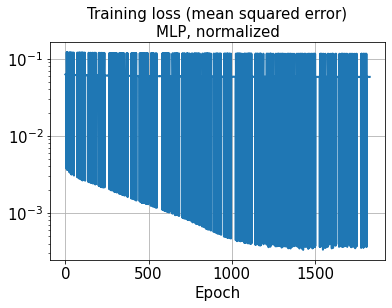

In [46]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nMLP, normalized', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

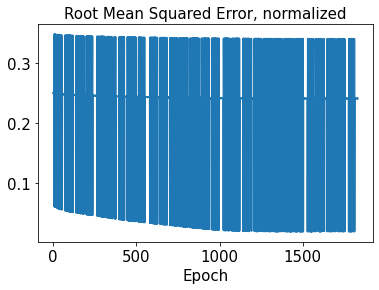

In [47]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error, normalized', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

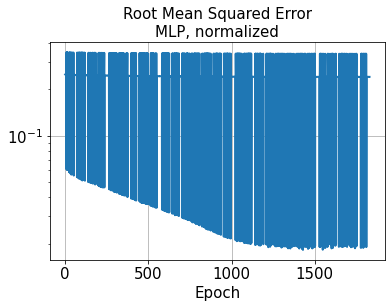

In [48]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error\nMLP, normalized', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [49]:
train_results = model.evaluate(x_train, y_train)

196/196 [==============================] - 1s 3ms/step - loss: 0.0573 - rmse: 0.2394


In [50]:
test_results = model.evaluate(x_test, y_test)

84/84 [==============================] - 0s 2ms/step - loss: 3.2017e-04 - rmse: 0.0179


In [51]:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)

84/84 [==============================] - 0s 1ms/step


In [52]:
model_directory = "D:\\TrainedModels\\20221126"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221126unsteadyPrediction_MLP_test"+str(test_rate)+ "_" + str(n_units) +"units_normalized.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [53]:
error_train_abs = np.abs(decoded_train - y_train)

In [54]:
error_test_abs = np.abs(decoded_test - y_test)

In [55]:
os.chdir(storage_dir)

In [56]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.9484738860817687


In [57]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.23331454245407


In [58]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [59]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

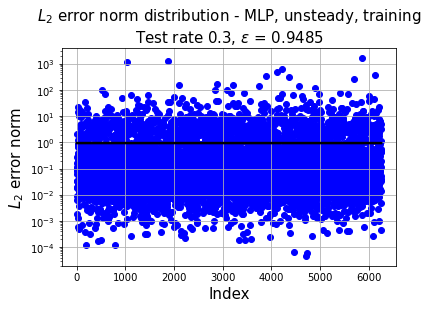

In [60]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, unsteady, training\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

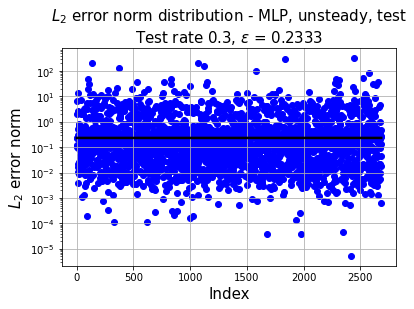

In [61]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, unsteady, test\nTest rate {0}, $\epsilon$ = {1:0.4f}'.format(test_rate, l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [62]:
index_train = np.unique(np.where(np.isin(y, y_train)))
index_test = np.unique(np.where(np.isin(y, y_test)))

In [63]:
iTrain=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
    
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [64]:
iTrain = np.array(iTrain)
iTest = np.array(iTest)

In [65]:
prediction = model.predict(x)

280/280 [==============================] - 0s 2ms/step


In [66]:
plt.plot(alpha, CD, 'k-', label='Ground truth')
plt.plot(alpha, cd, 'k--', label='Predicted value')
plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
plt.xlabel('AoA (degree)')
plt.ylabel('$C_m$')
plt.title('Gurney flap not attached (NACA0018)\n$C_m$ prediction, L2 error=%.4f' % l2_error_Cd, fontsize=15)
plt.legend(loc='upper left')
plt.ylim([0, 0.12])
plt.grid()
savename1 = "CdComparison_NACA0018.jpg"
plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

NameError: name 'alpha' is not defined

In [ ]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90,90,45]
for i in range(0, 11):
    iTrain = []
    iTest = []
    
    predictedValue = model.predict(x[checkpoint[i]:checkpoint[i+1],:])
    y_corres = y[checkpoint[i]:checkpoint[i+1],:]
    
    l2_error = np.sqrt(np.sum((predictedValue - y_corres)**2) / (np.sum(y_corres)**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error{0:0.4f}'.format(l2_error))
    else:
        print('L2 error: {0:0.4f}'.format(l2_error))
    
    '''cl = predicted[n_alpha*i:n_alpha*(i+1),1]
    cd = predicted[n_alpha*i:n_alpha*(i+1),0]
    
    CL = y[n_alpha*i:n_alpha*(i+1),1]
    CD = y[n_alpha*i:n_alpha*(i+1),0]
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])

    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)
    iTest = np.array(iTest)
    
    alpha_train = []
    alpha_test = []'''
    
    '''for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)[:,0]
    aTest = np.array(alpha_test)[:,0]'''
    
    if i==0:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_m$')
        plt.title('Gurney flap not attached (NACA0018)\n$C_m$ prediction, L2 error=%.4f' % l2_error, fontsize=15)
        plt.legend(loc='upper left')
        #plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CmComparison_NACA0018.jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()
    
    else:
        plt.plot(alpha, CD, 'k-', label='Ground truth')
        plt.plot(alpha, cd, 'k--', label='Predicted value')
        plt.scatter(aTrain, iTrain[:,0], color='b', label='Training set')
        plt.scatter(aTest, iTest[:,0], color='r', label='Test set')
        plt.xlabel('AoA (degree)')
        plt.ylabel('$C_m$')
        plt.title('Gurney flap attached h=%.2f, beta=%d\nCm prediction, L2 error=%.4f'%(h[i], beta[i],l2_error), fontsize=15)
        plt.legend(loc='upper left')
        #plt.ylim([0, 0.12])
        plt.grid()
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
        plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
        plt.show()